### Лабораторная работа №8: Text classification  
##### Деев Григорий Тимофеевич

1. [загрузить датасет](#1)
2. [вывод записей](#2)
3. [повторяющиеся участки](#3)
4. [стеммер](#4)
5. [TfIdf](#5)
6. [sklearn.linear_model.LogisticRegression()](#6)
7. [подбор гиперпараметров](#7)
8. [итоги](#8)
9. [confusion matrix](#9)

##### <a name="1"></a>	загрузить датасет
Найти и загрузить любой датасет для классификации текстов (бинарная или многоклассовая). Для примера можете тренироваться с датасетом billdoard_dataset.csv (который я использую в заготовке tfidf-example.ipynb), но потом нужно найти собстивенные датасеты и переделавать под них.
Если же говорить о датасете billdoard_dataset.csv, то там мы можем свести задачу к бинарной классификации, прогнозировать класс популярности объявления (если num_counts выше медианы — один класс, иначе другой).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79371\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79371\AppData\Roaming\nltk_data...


True

In [6]:
data = pd.read_csv(r'Emotion_final.csv')
data.head(100)

Text  Emotion
0                             i didnt feel humiliated  sadness
1   i can go from feeling so hopeless to so damned...  sadness
2    im grabbing a minute to post i feel greedy wrong    anger
3   i am ever feeling nostalgic about the fireplac...     love
4                                i am feeling grouchy    anger
..                                                ...      ...
95  i feel like throwing away the shitty piece of ...  sadness
96  im starting to feel wryly amused at the banal ...    happy
97  i find every body beautiful and only want peop...    happy
98  i hear are owners who feel victimized by their...  sadness
99  i say goodbye to the fam theyre all sad a cryi...    anger

[100 rows x 2 columns]

##### <a name="2"></a>	вывод записей
Выводите в цикле целиком текст первых нескольких записей (этот этап естественно также должен быть отражён в блокноте), смотрите на тексты глазами, много думаете.

In [7]:
df = data.sample(1000)
df['Text'].values[:300]

array(['i feel personally hated when i read their poems',
       'i last talked to her and now i feel all bouncy again i shall sleep well tonight methinks',
       'i feel optimistic about the remainder of our time in the military',
       'i feel though its pretty dangerous to to apply one strategy to match',
       'i feel more of a sense of longing than of loss',
       'i feel that the media cannot be resolved effectively',
       'i just want u to know how u make me feel unimportant ignored jealous and more middle school level adjectives',
       'i feeling boring',
       'i feel hated and isolated but it doesn t hurt',
       'i could barely leave the house and i was feeling a lot of isolation and i hated the lack of control i had over my own life because everyone else i knew was moving on with theirs',
       'i feel the divine presence merge into mine',
       'i feel that we are heading for an abyss that has been created by the greedy the too greedy and the far too greedy',
 

##### <a name="3"></a>	повторяющиеся участки
Находите малоинформативные повторяющиеся участки в текстах: это могут быть, например, стандартные «шапки» или стандартные «подвалы» (стандартные приветствия или подписи), или, например, все цифры (если в данном контексте они малоинформативны) или все MD5-хеши, или web-адреса и т.п. — всё что по вашей оценке не несёт информационной нагрузки и пользы для классификации — всё это удаляем (с помощью регекспов или как-то ещё через функции работы со строками). Чтобы не зашумлять тексты малоинфомативными мусорными n-граммами.

In [8]:
df['Cleaned'] = df['Text'].str.replace('@', '')
stopwords = stopwords.words('english')
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text
df['Cleaned'] = df['Cleaned'].apply(lambda text : remove_stopwords(text.lower()))
df['Cleaned'] = df['Cleaned'].apply(lambda x : x.split())
df.head(100)

Text  Emotion  \
19818    i feel personally hated when i read their poems  sadness   
13190  i last talked to her and now i feel all bouncy...    happy   
8447   i feel optimistic about the remainder of our t...    happy   
5405   i feel though its pretty dangerous to to apply...    anger   
1233      i feel more of a sense of longing than of loss     love   
...                                                  ...      ...   
7125   i personally would gladly pay someone more jus...    happy   
19207               im feeling rather listless right now  sadness   
18330               im feeling kind of petty and selfish    anger   
13875  i cannot stop loving you and it just feels ama...    happy   
607    i admire athleticism i feel like i would be mo...    happy   

                                                 Cleaned  
19818             [feel, personally, hated, read, poems]  
13190  [last, talked, feel, bouncy, shall, sleep, wel...  
8447       [feel, optimistic, remainder, time, military]  
5405   [feel, though, pretty, dangerous, apply, one, ...  
1233                        [feel, sense, longing, loss]  
...                                                  ...  
7125   [personally, would, gladly, pay, someone, trea...  
19207             [im, feeling, rather, listless, right]  
18330                [im, feeling, kind, petty, selfish]  
13875  [cannot, stop, loving, feels, amazing, really,...  
607    [admire, athleticism, feel, like, would, enter...  

[100 rows x 3 columns]

##### <a name="4"></a>	стеммер
Опциональный шаг: Проходимся по текстам стеммером (пример стемминга есть в tfidf-example.ipynb: если PyStemmer стеммер не заработает, найдите другие на просторах интернета и поделитесь в общем чате вашими рабочими вариантами) — приводим все слова к нормальной форме. Все результаты должны быть в двух вариантах: без стеммера и со стеммером.
Можно использовать не стеммер, а лемматизатор (например, pymorph2)

In [10]:
wordnet = WordNetLemmatizer()
df['Lemmatized'] = df['Cleaned'].apply(lambda x : [wordnet.lemmatize(i) for i in x])
df['Lemmatized'] = df['Lemmatized'].apply(lambda x : ' '.join([w for w in x]))
df['Lemmatized'] = df['Lemmatized'].apply(lambda x : ' '.join([w for w in x.split()]))

In [11]:
df['Emotion'] = df['Emotion'].map({'surprise': 0,
                                   'sadness': 1,
                                   'love': 2,
                                   'fear': 3,
                                   'happy': 4,
                                   'anger': 5
                                  })

In [12]:
df.head(3)

Text  Emotion  \
19818    i feel personally hated when i read their poems        1   
13190  i last talked to her and now i feel all bouncy...        4   
8447   i feel optimistic about the remainder of our t...        4   

                                                 Cleaned  \
19818             [feel, personally, hated, read, poems]   
13190  [last, talked, feel, bouncy, shall, sleep, wel...   
8447       [feel, optimistic, remainder, time, military]   

                                              Lemmatized  
19818                    feel personally hated read poem  
13190  last talked feel bouncy shall sleep well tonig...  
8447             feel optimistic remainder time military

##### <a name="5"></a>	TfIdf
Создаём матрицу TfIdf с помощью TfidfVectorizer (пример есть в моём блокноте), не забудьте про стоп-слова (stop_words), наряду со словами из библиотеки stop_words можете добавить свои стоп-слова, если по текстам видите, что они мусорные и незначимые.
Вначале при инициализации TfidfVectorizer можете оставить значения по умолчанию, которые даны в моём примере.

In [13]:
tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.8,
    max_features = 2500,
    min_df = 0.002,
    use_idf = True,
    ngram_range = (1, 3)
)
z = tfidf_vectorizer.fit_transform(df['Lemmatized']).toarray()
z.shape

(1000, 1559)

##### <a name="6"></a>	sklearn.linear_model.LogisticRegression()
Применяем sklearn.linear_model.LogisticRegression() (либо другой классификатор по вашему выбору) к получившейся матрице TfIdf, проводим классификацию (здесь и далее всё с помощью кросс-валидации!), выводим получившиеся метрики качества (accuracy для multiclass или f1 / classification_report для бинарной).

In [15]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm


clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_validate(clf, z, df['Emotion'], cv=5, scoring=['accuracy'])
scores

{'fit_time': array([6.60438204, 5.17626643, 8.28513288, 4.3397789 , 3.72772074]),
 'score_time': array([0.82181478, 0.62216687, 0.63867974, 0.52638531, 0.40345263]),
 'test_accuracy': array([0.57 , 0.54 , 0.535, 0.54 , 0.535])}

In [16]:
y_pred = clf.fit(z[:500], df['Emotion'][:500]).predict(z[500:])
print(classification_report(df['Emotion'][500:], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.50      0.64      0.56       162
           2       1.00      0.05      0.09        44
           3       0.55      0.12      0.19        52
           4       0.47      0.73      0.57       166
           5       0.56      0.15      0.23        62

    accuracy                           0.49       500
   macro avg       0.51      0.28      0.27       500
weighted avg       0.53      0.49      0.43       500



##### <a name="7"></a>	подбор гиперпараметров
Теперь самое интересное: оптимизация и подбор наилучших гиперпатаметров и способа предобработки текстов.
Играемся с параметрами TfidfVectorizer: max_df, min_df, max_features, ngram_range ((1,2) или (1,3)), чтобы максимально повысить качество предсказаний (в качестве метрики качества для оптимизации: accuracy для многоклассовой и f1 для бинарной классификации).
В идеале если вы сможете всё это завернуть в свой Pipeline и подобрать лучшие гиперпараметры пайплайна через GridSearchCV.
Помимо указанных параметров TfidfVectorizer также попробуйте несколько разных значений силы регуляризации: LogisticRegression: C = [ 0.1, 1, 10 ].
И не забудьте что всё это ещё надо попробовать со стеммером и без: наличие фазы стемминга тоже, считайте, гиперпатаметр. Если повезёт, то все гиперпараметры вы можете засунуть в Pipeline и найти наилучшее их сочетание через GridSearhCV, в худшем случае что-то придётся перебирать в цикле (но, по крайней мере, частично надо автоматизировать через GridSearhCV).

В самом худшем случае, если всё совсем плохо и с автоматизацией не получается совсем, можете подобрать / покрутить все параметры ручками, но тогда запишите куда-то промежуточные результаты, что у вас получались при каком сочетании гиперпараметров.

In [19]:
df = data.sample(1000)

df['Cleaned'] = df['Text'].str.replace('@', '')
df['Cleaned'] = df['Cleaned'].str.replace(r'http\S+', '')
df['Cleaned'] = df['Cleaned'].str.replace('[^a-zA-Z]', ' ')

df['Cleaned'] = df['Cleaned'].apply(lambda text : remove_stopwords(text.lower()))
df['Cleaned'] = df['Cleaned'].apply(lambda x : x.split())

df['Emotion'] = df['Emotion'].map({'surprise': 0,
                                   'sadness': 1,
                                   'love': 2,
                                   'fear': 3,
                                   'happy': 4,
                                   'anger': 5
                                  })

df['Cleaned'] = df['Cleaned'].apply(lambda x : ' '.join([w for w in x]))
df['Cleaned'] = df['Cleaned'].apply(lambda x : ' '.join([w for w in x.split()]))

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


grid_params = {
    'tfidf__max_df': np.arange(0.6, 1, 0.2),
    'tfidf__min_df': np.arange(0.002, 0.01, 0.004),
    'tfidf__max_features': np.arange(3000, 5000, 2000),
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'svm__C': np.arange(1, 5, 2),
    'svm__kernel': ['linear', 'poly', 'rbf']
}

pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('svm', svm.SVC())
    ]
)

gs = GridSearchCV(pipe, grid_params, n_jobs=1, cv=5, verbose=2, scoring='accuracy')

In [37]:
gs = gs.fit(df['Cleaned'].values, df['Emotion'])

model = gs.best_estimator_
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_df=0.6, tfidf__max_features=3000, tfidf__min_df=0.002, tfidf__ngram_range=(1, 2); total time=   0.6s
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_df=0.6, tfidf__max_features=3000, tfidf__min_df=0.002, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_df=0.6, tfidf__max_features=3000, tfidf__min_df=0.002, tfidf__ngram_range=(1, 2); total time=   0.3s
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_df=0.6, tfidf__max_features=3000, tfidf__min_df=0.002, tfidf__ngram_range=(1, 2); total time=   0.3s
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_df=0.6, tfidf__max_features=3000, tfidf__min_df=0.002, tfidf__ngram_range=(1, 2); total time=   0.2s
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_df=0.6, tfidf__max_features=3000, tfidf__min_df=0.002, tfidf__ngram_range=(1, 3); total time=   0.6s
[CV] END svm__C=1, svm__kernel=l

{'svm__C': 3,
 'svm__kernel': 'linear',
 'tfidf__max_df': 0.8,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 0.002,
 'tfidf__ngram_range': (1, 3)}

##### <a name="8"></a>	итоги
Подводим итоги: параметры наилучшей модели и получившиеся при них метрики классификации.

In [38]:
gs.best_params_

{'svm__C': 3,
 'svm__kernel': 'linear',
 'tfidf__max_df': 0.8,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 0.002,
 'tfidf__ngram_range': (1, 3)}

In [39]:
y_pred = model.predict(df['Cleaned'][500:])
print(classification_report(df['Emotion'][500:], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.99      1.00      1.00       145
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00        72
           4       0.99      1.00      1.00       155
           5       1.00      0.99      0.99        69

    accuracy                           1.00       500
   macro avg       1.00      0.99      0.99       500
weighted avg       1.00      1.00      1.00       500



##### <a name="9"></a>	confusion matrix
Строим confusion matrix (см. ЛР4) для оценки того, какие ошибки классификатор допускает наиболее часто.

<AxesSubplot: >

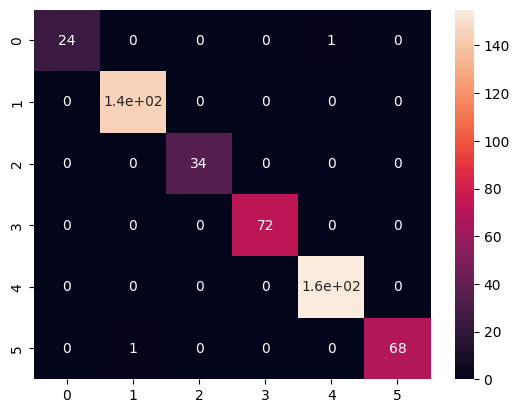

In [40]:
from sklearn.metrics import confusion_matrix


confusion_scores = confusion_matrix(df['Emotion'][500:], y_pred)
sns.heatmap(confusion_scores, annot=True)